# Visualization of the CTLearn output
The output of CTLearn are stored in HDF5 format using pandas. 

### Import libraries
First, we need to import some libraries. 

In [1]:
# Data handling with numpy
import numpy as np
#np.set_printoptions(threshold=np.inf)

import os

# Metric handling wit sklearn
from sklearn import metrics

# Reading the HDF5 file with pandas
import pandas as pd

# Plotting libraries
import ctaplot
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
# (Default ctaplot) energy binning 
E_bin = np.logspace(np.log10(2.51e-02), 2, 19)
E = ctaplot.ana.logbin_mean(E_bin)

h5_dir = '/Users/tmiener/deeplearning/lst_mono/h5/'
cuts = ['nocut', 'lowcut', 'midcut', 'highcut']
colors = ['blue', 'green', 'yellow', 'red']
fmts = ['o', 'd','^','v']

## Particle classification


AUCs:
   nocut:
      pointlike: 0.8562602968281926 +- 0.007473933847666944
      diffuse  : 0.8476418289655866 +- 0.0018977702349252277
   lowcut:
      pointlike: 0.8692553703655943 +- 0.006431722955693046
      diffuse  : 0.8726277631578133 +- 0.0013815591685028563
   midcut:
      pointlike: 0.9083254410846188 +- 0.004550913338137561
      diffuse  : 0.9113346149399589 +- 0.002483559381085715
   highcut:
      pointlike: 0.983033791165916 +- 0.001605995824990042
      diffuse  : 0.9755128504242508 +- 0.0013227281645944282


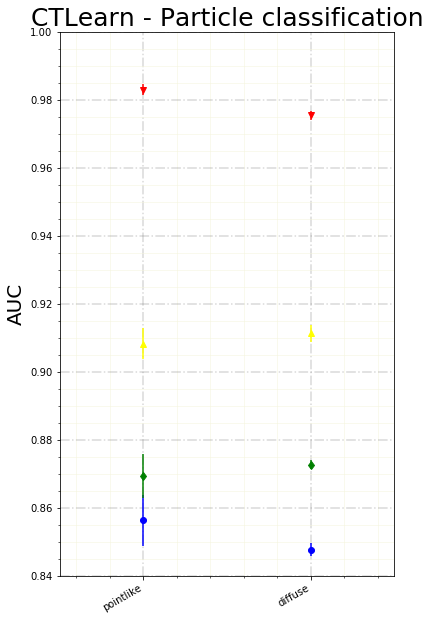

In [2]:
plt.figure(figsize=(6,10))
print("AUCs:")
for ind, cut in enumerate(cuts):
    auc_mean = []
    auc_std = []
    gammatyps = ['pointlike', 'diffuse']
    einszwei = [0,1]
    for ind_typ, gammatyp in enumerate(gammatyps):

        files = np.array([x for x in os.listdir(h5_dir) if x.startswith("particle_{}".format(cut)) and x.endswith(".h5")])
    
        auc_per_seed = []
        acc_per_seed = [] 
        acc_gamma_per_seed = []
        acc_proton_per_seed = []
        seeds = []
        for file in files:
              
            seed = int(file.replace("particle_{}_".format(cut),'').replace(".h5".format(cut),''))
            seeds.append(seed)
            data = pd.HDFStore(h5_dir+file, 'r')
            
            proton_prediction = data['proton']
            proton_mc_particle = np.array(proton_prediction['mc_particle']).astype(int)
            proton_reco_particle = np.array(proton_prediction['reco_particle']).astype(int)
            proton_reco_gammaness = np.array(proton_prediction['reco_gammaness']).astype(float)
        
            if '/gamma_{}'.format(gammatyp) in data.keys():
                gamma_prediction = data['gamma_{}'.format(gammatyp)]
                gamma_mc_particle = np.array(gamma_prediction['mc_particle']).astype(int)
                gamma_reco_particle = np.array(gamma_prediction['reco_particle']).astype(int)
                gamma_reco_gammaness = np.array(gamma_prediction['reco_gammaness']).astype(float)
            
            # Concatenate the protons with the gammas (diffuse and pointlike)
            mc_particle = np.concatenate((proton_mc_particle, gamma_mc_particle))
            reco_particle = np.concatenate((proton_reco_particle, gamma_reco_particle))
            reco_gammaness = np.concatenate((proton_reco_gammaness, gamma_reco_gammaness))
            
            fpr, tpr, thresholds = metrics.roc_curve(mc_particle, reco_gammaness)
            auc_per_seed.append(metrics.auc(fpr, tpr))
            
      
        auc_mean.append(np.mean(auc_per_seed, axis=0))
        auc_std.append(np.std(auc_per_seed, axis=0))

    plt.errorbar(gammatyps, auc_mean, yerr=auc_std, fmt = fmts[ind], color=colors[ind])
    print("   {}:".format(cut))
    print("      pointlike: {} +- {}".format(auc_mean[0], auc_std[0]))
    print("      diffuse  : {} +- {}".format(auc_mean[1], auc_std[1]))
    
plt.ylabel('AUC', fontsize=20)
plt.ylim(0.84,1.0)
#major and minor grid lines
plt.grid(b=True, which='major', color='gray', alpha=0.3, linestyle='dashdot', lw=1.5)
plt.minorticks_on()
plt.grid(b=True, which='minor', color='beige', alpha=0.5, ls='-', lw=1)
plt.yticks([0.84,0.86,0.88,0.90,0.92,0.94,0.96,0.98,1.0])
plt.title("CTLearn - Particle classification",fontsize=25)
plt.margins(0.5)
plt.xticks(einszwei, gammatyps, rotation=30, ha="right")
plt.savefig("/Users/tmiener/deeplearning/lst_mono/auc_ctlearn.png")
plt.show()

## Energy regression

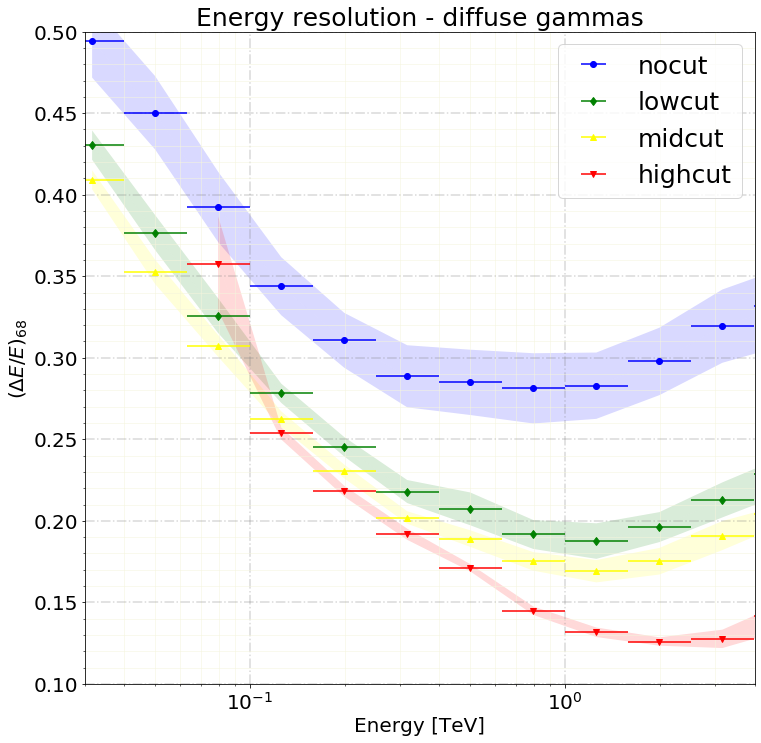

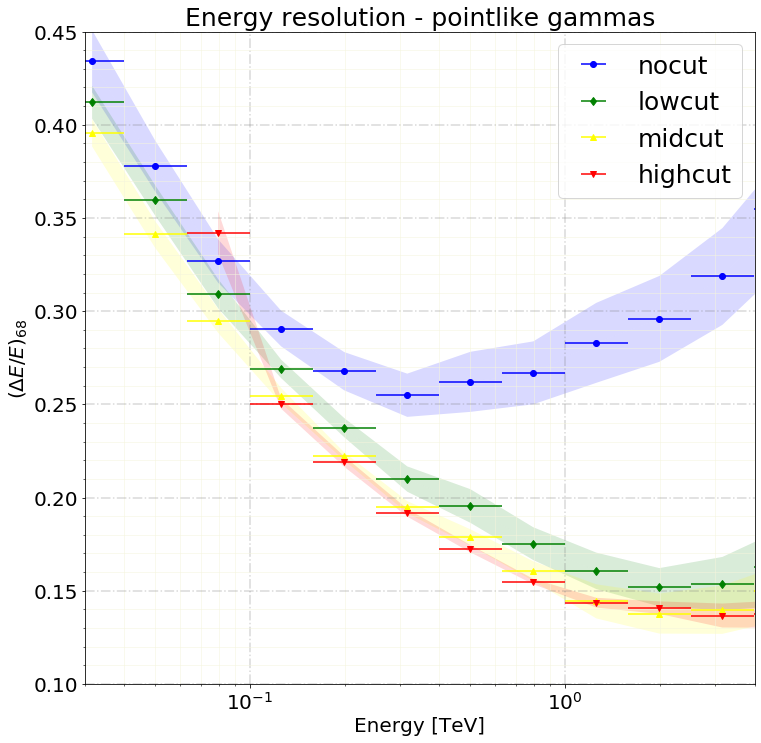

In [3]:
for gammatyp in ['diffuse', 'pointlike']:
    fig, ax = plt.subplots(1,figsize=(12,12))

    for ind, cut in enumerate(cuts):
        files = np.array([x for x in os.listdir(h5_dir) if x.startswith("energy_{}".format(cut)) and x.endswith(".h5")])
    
        eres_per_seed = [] 
        for file in files:
            seed = int(file.replace("energy_{}_".format(cut),'').replace(".h5".format(cut),''))

            data = pd.HDFStore(h5_dir+file, 'r')
    
            if '/gamma_{}'.format(gammatyp) in data.keys():
                prediction_data = data['/gamma_{}'.format(gammatyp)]
                mc_energy = np.array(prediction_data['mc_energy'])
                reco_energy = np.array(prediction_data['reco_energy'])
                ebin, eres = ctaplot.ana.energy_resolution_per_energy(mc_energy, reco_energy)
                eres_per_seed.append(eres[:,0])
                #ax = ctaplot.plot_energy_resolution(mc_energy, reco_energy, label="{}".format(file))

        mean = np.mean(eres_per_seed, axis=0)
        #print(mean)
        std = np.std(eres_per_seed, axis=0)
        #print(std)
        if cut == "highcut":
            ax.errorbar(E[2:], mean[2:], xerr=(E[2:] - E_bin[2:][:-1], E_bin[2:][1:] - E[2:]),
                        label = '{}'.format(cut), fmt = fmts[ind], color=colors[ind])
            ax.fill_between(E[2:], mean[2:], mean[2:]+std[2:],color=colors[ind], alpha=0.15, linewidth=0)
            ax.fill_between(E[2:], mean[2:], mean[2:]-std[2:],color=colors[ind], alpha=0.15, linewidth=0)
        else:
            ax.errorbar(E, mean, xerr=(E - E_bin[:-1], E_bin[1:] - E),
                        label = '{}'.format(cut), fmt = fmts[ind], color=colors[ind])
            ax.fill_between(E, mean, mean+std,color=colors[ind], alpha=0.15, linewidth=0)
            ax.fill_between(E, mean, mean-std,color=colors[ind], alpha=0.15, linewidth=0)

    # Scale, labels and title
    ax.set_ylabel(r"$(\Delta E/E)_{68}$",fontsize=20)
    if gammatyp == 'diffuse':
        ax.set_ybound(0.1,0.5)
        ax.set_yticks([0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5])
    else:
        ax.set_ybound(0.1,0.45)
        ax.set_yticks([0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45])
    ax.set_xlabel("Energy [TeV]",fontsize=20)
    ax.set_xscale('log')
    ax.set_xbound(3e-2,4e0)
    ax.set_title('Energy resolution - {} gammas'.format(gammatyp),fontsize=25)
    ax.tick_params(labelsize=20)

    #major and minor grid lines
    plt.grid(b=True, which='major', color='gray', alpha=0.3, linestyle='dashdot', lw=1.5)
    plt.minorticks_on()
    plt.grid(b=True, which='minor', color='beige', alpha=0.5, ls='-', lw=1)

    ax.legend(loc='upper right',fontsize=25)
    plt.savefig("/Users/tmiener/deeplearning/lst_mono/energyresolution_{}gammas_CTLearn.png".format(gammatyp))
    plt.show()

## Arrival direction regression 

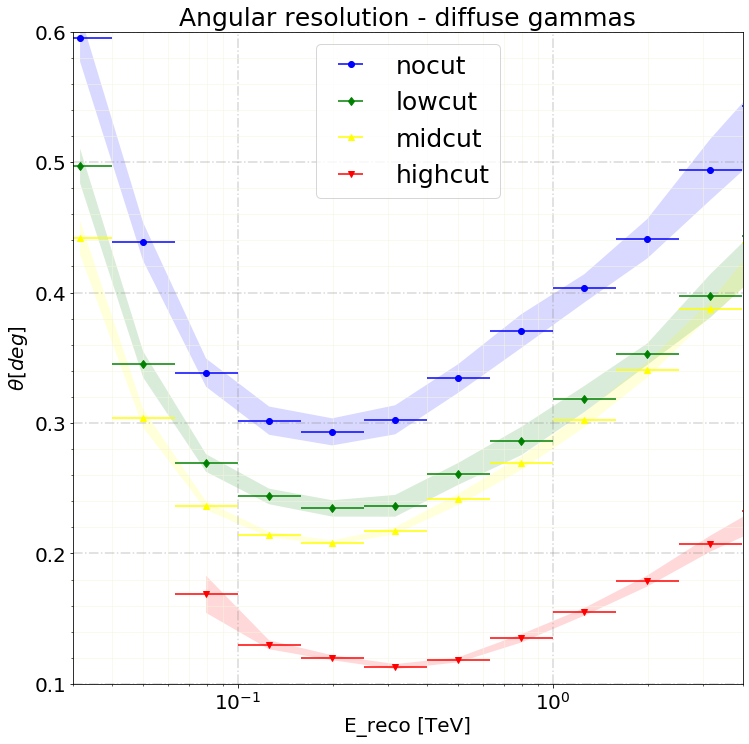

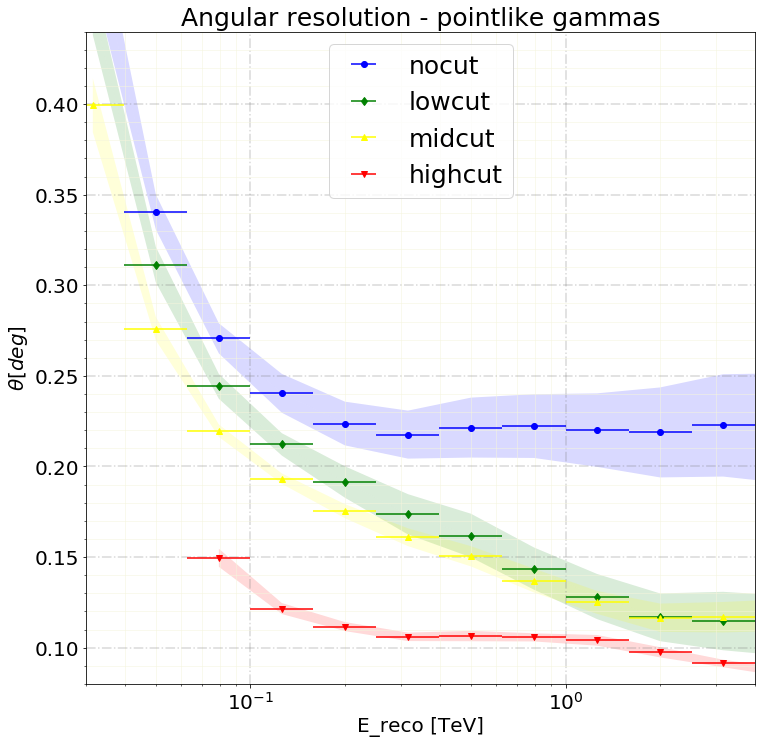

In [4]:
for gammatyp in ['diffuse', 'pointlike']:
    fig, ax = plt.subplots(1,figsize=(12,12))

    for ind, cut in enumerate(cuts):
        arrdir_files = np.array([x for x in os.listdir(h5_dir) if x.startswith("arrdir_{}".format(cut)) and x.endswith(".h5")])
        energy_files = np.array([x for x in os.listdir(h5_dir) if x.startswith("energy_{}".format(cut)) and x.endswith(".h5")])
        angres_per_seed = []  
        for arrdir_file in arrdir_files:
            seed = int(arrdir_file.replace("arrdir_{}_".format(cut),'').replace(".h5".format(cut),''))            
            if not any(str(seed) in energy_file for energy_file in energy_files): 
                continue
            arrdir_data = pd.HDFStore(h5_dir+arrdir_file, 'r')
            energy_data = pd.HDFStore(h5_dir+"energy_{}_{}.h5".format(cut, seed), 'r')

            if '/gamma_{}'.format(gammatyp) in data.keys():
                
                prediction_data = arrdir_data['/gamma_{}'.format(gammatyp)]
                energy_prediction_data = energy_data['/gamma_{}'.format(gammatyp)]
                reco_energy = np.array(energy_prediction_data['reco_energy'])
                mc_energy = np.array(energy_prediction_data['mc_energy'])

                mc_alt = np.array(prediction_data['mc_altitude'])
                reco_alt = np.array(prediction_data['reco_altitude'])
                mc_az = np.array(prediction_data['mc_azimuth'])
                reco_az = np.array(prediction_data['reco_azimuth'])
                ebin, angres = ctaplot.ana.angular_resolution_per_energy(reco_alt, reco_az, mc_alt, mc_az, reco_energy, bias_correction=False)
                angres = np.degrees(angres)
                angres_per_seed.append(angres[:,0])
                #ax = ctaplot.plot_angular_resolution_per_energy(reco_alt, reco_az, mc_alt, mc_az, reco_energy, bias_correction=False, label="{}".format(arrdir_file)) 
           
        mean = np.mean(angres_per_seed, axis=0)
        #print(mean)
        std = np.std(angres_per_seed, axis=0)
        #print(std)
        if cut == "highcut":
            ax.errorbar(E[2:], mean[2:], xerr=(E[2:] - E_bin[2:][:-1], E_bin[2:][1:] - E[2:]),
                        label = '{}'.format(cut), fmt = fmts[ind], color=colors[ind])
            ax.fill_between(E[2:], mean[2:], mean[2:]+std[2:],color=colors[ind], alpha=0.15, linewidth=0)
            ax.fill_between(E[2:], mean[2:], mean[2:]-std[2:],color=colors[ind], alpha=0.15, linewidth=0)
        else:
            ax.errorbar(E, mean, xerr=(E - E_bin[:-1], E_bin[1:] - E),
                        label = '{}'.format(cut), fmt = fmts[ind], color=colors[ind])
            ax.fill_between(E, mean, mean+std,color=colors[ind], alpha=0.15, linewidth=0)
            ax.fill_between(E, mean, mean-std,color=colors[ind], alpha=0.15, linewidth=0)

    # Scale, labels and title
    ax.set_ylabel(r'$\theta [deg]$',fontsize=20)
    if gammatyp == 'diffuse':
        ax.set_ybound(0.1,0.6)
        ax.set_yticks([0.1,0.2,0.3,0.4,0.5,0.6])
    else:
        ax.set_ybound(0.08,0.44)
        ax.set_yticks([0.1,0.15,0.2,0.25,0.3,0.35,0.4])
    ax.set_xlabel("E_reco [TeV]",fontsize=20)
    ax.set_xscale('log')
    ax.set_xbound(3e-2,4e0)
    ax.set_title('Angular resolution - {} gammas'.format(gammatyp),fontsize=25)
 
    ax.tick_params(labelsize=20)

    #major and minor grid lines
    plt.grid(b=True, which='major', color='gray', alpha=0.3, linestyle='dashdot', lw=1.5)
    plt.minorticks_on()
    plt.grid(b=True, which='minor', color='beige', alpha=0.5, ls='-', lw=1)
    ax.legend(loc='upper center',fontsize=25)
   
    plt.savefig("/Users/tmiener/deeplearning/lst_mono/angularresolution_{}gammas_CTLearn.png".format(gammatyp))
    plt.show()
        
